# A Classification Neural Network Designed for Multiclass Pose Detection with Pytorch and Scklearn

# Preprocessing data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mediapipe as mp 
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# uncomment it to move to gpu
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

device(type='cuda', index=0)

In [3]:
# Get dataset from csv
df = pd.read_csv('hands-coords.csv')
df.head()

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
0,OPEN,0.394880,0.587393,-0.000011,0.459958,0.568501,-0.038999,0.512309,0.496059,-0.053491,...,-0.063434,0.328500,0.320133,-0.093945,0.317701,0.273566,-0.121936,0.310020,0.227551,-0.146719
1,OPEN,0.396461,0.598194,-0.000083,0.462247,0.567778,-0.038495,0.516739,0.495861,-0.056562,...,-0.059121,0.333933,0.318645,-0.087067,0.323522,0.273325,-0.112867,0.314453,0.228451,-0.134094
2,OPEN,0.398345,0.601678,-0.000082,0.464170,0.570422,-0.036361,0.519565,0.497987,-0.054392,...,-0.056319,0.337847,0.320089,-0.082289,0.327687,0.274538,-0.106470,0.319171,0.229858,-0.124656
3,OPEN,0.402195,0.603170,-0.000089,0.466884,0.571492,-0.034957,0.521306,0.499275,-0.053021,...,-0.061656,0.341986,0.319025,-0.088807,0.332003,0.272325,-0.113803,0.323125,0.226209,-0.132762
4,OPEN,0.404677,0.602536,-0.000092,0.469733,0.570086,-0.034000,0.524145,0.498155,-0.051666,...,-0.057575,0.344240,0.316547,-0.082856,0.334007,0.270097,-0.106922,0.324559,0.224519,-0.124947


In [4]:
df.shape

(5011, 64)

<AxesSubplot:xlabel='class', ylabel='count'>

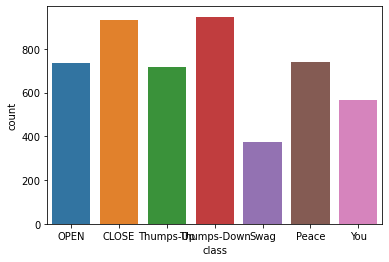

In [5]:
sns.countplot(x = 'class', data=df)

<AxesSubplot:title={'center':'Y axis'}, xlabel='class'>

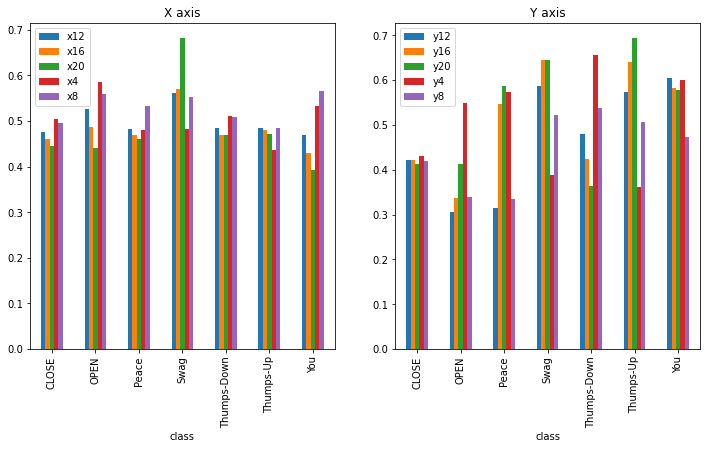

In [6]:
# Hand Model Visualization
df_pivot_x = pd.pivot_table(
    df, 
    values=["x4", "x8", "x12", "x16", "x20"],
    index="class", 
    aggfunc=np.mean
)
df_pivot_y = pd.pivot_table(
    df, 
    values=["y4", "y8", "y12", "y16", "y20"],
    index="class", 
    aggfunc=np.mean
)
fig, axes = plt.subplots(1,2,figsize=(12,6))
df_pivot_x.plot(kind="bar", title="X axis", ax=axes[0])
df_pivot_y.plot(kind="bar", title="Y axis", ax=axes[1])


In [7]:
# Encode the class
le = LabelEncoder()
le.fit(df['class'])
df['class_encoded'] = le.transform(df['class'])

X = df.drop(['class', 'class_encoded'], axis=1)
y = df['class_encoded']

In [8]:
# Divide it to trainval and test splits
X_trainval, X_test, y_trainval, y_test = train_test_split(X,y, stratify=y, test_size=0.3, random_state=69)


# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [9]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

# Neural Network Design with PyTorch

## Creating custom datasets

In [10]:
class GestureDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.y_data)
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

In [11]:
train_dataset = GestureDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = GestureDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = GestureDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

## Weighted Sampling

Because there’s a class imbalance, we use stratified split to create our train, validation, and test sets.
While it helps, it still does not ensure that each mini-batch of our model see’s all our classes. We need to over-sample the classes with less number of values. To do that, we use the WeightedRandomSampler.

In [12]:
def get_class_distribution(obj, max_num_class):
    count_dict = {}
    for i in range(max_num_class+1):
        count_dict[i] = 0
    
    for i in obj:
        count_dict[i] += 1
            
    return count_dict

In [13]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [14]:
class_count = [i for i in get_class_distribution(y_train, int(max(target_list))).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0017, 0.0022, 0.0021, 0.0043, 0.0017, 0.0022, 0.0028])


In [15]:
class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

## Modeling

In [16]:
class GestureClassifierNet(nn.Module):
    def __init__(self, num_feature, num_class):
        super(GestureClassifierNet, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x
        

In [17]:
EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = max(y) + 1

model = GestureClassifierNet(num_feature = NUM_FEATURES, num_class = NUM_CLASSES)

# uncomment it to move to gpu
#model.to(device)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler,
                          drop_last=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

# uncomment it to move to gpu
#criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

GestureClassifierNet(
  (layer_1): Linear(in_features=63, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Training the Model

This function takes y_pred and y_test as input arguments. We then apply log_softmax to y_pred and extract the class which has a higher probability.
After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [18]:
# accuracy function
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [19]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [20]:
# Training
for e in range(EPOCHS):

    train_epoch_loss = 0
    train_epoch_acc = 0

    # TRAINING
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        # uncomment it to move to gpu
        #X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            # uncomment it to move to gpu
            #X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

    if e%50==0:
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Epoch 000: | Train Loss: 0.54197 | Val Loss: 0.07798 | Train Acc: 91.650| Val Acc: 100.000
Epoch 050: | Train Loss: 0.01372 | Val Loss: 0.00888 | Train Acc: 99.726| Val Acc: 99.715


In [21]:
print(f'Final: Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Final: Train Loss: 0.00222 | Val Loss: 0.00001 | Train Acc: 99.909| Val Acc: 100.000


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

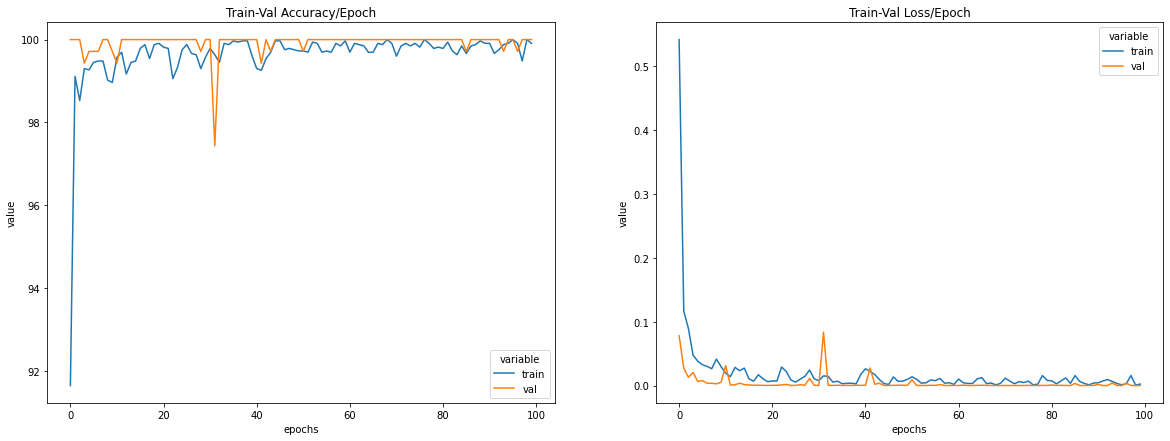

In [22]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Prediction and Evaluation

In [23]:
y_pred_list = []
with torch.no_grad():
    test_loss=0
    test_acc=0
    model.eval()
    for X_batch, Y_batch in test_loader:
        # uncomment it to move to gpu
        # X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

        test_it_loss = criterion(y_test_pred, Y_batch)
        test_it_acc = multi_acc(y_test_pred, Y_batch)
        
        test_loss += test_it_loss.item()
        test_acc += test_it_acc.item()

    loss_stats['test'] = (test_loss/len(test_loader))
    accuracy_stats['test'] = (test_acc/len(test_loader))
        

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

loss_stats['test'], accuracy_stats['test']

(1.5567336459616687e-05, 100.0)

<AxesSubplot:>

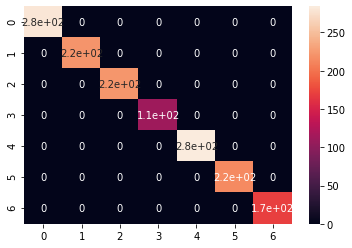

In [24]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

In [25]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       280
           1       1.00      1.00      1.00       221
           2       1.00      1.00      1.00       222
           3       1.00      1.00      1.00       112
           4       1.00      1.00      1.00       284
           5       1.00      1.00      1.00       215
           6       1.00      1.00      1.00       170

    accuracy                           1.00      1504
   macro avg       1.00      1.00      1.00      1504
weighted avg       1.00      1.00      1.00      1504



## Live Detection

In [26]:
mp_drawing = mp.solutions.drawing_utils # Drawing helper
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic

### Holistic Model

In [27]:
# import traceback
# cap = cv2.VideoCapture(0)
# # Initiate holistic model
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     while cap.isOpened():
#         ret, frame = cap.read()
        
#         # Recolor Feed
#         image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         image.flags.writeable = False        
        
#         # Make Detections
#         results = holistic.process(image)
#         # print(results.face_landmarks)
        
#         # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
#         # Recolor image back to BGR for rendering
#         image.flags.writeable = True   
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
#         # 1. Draw face landmarks
#         mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
#                                  mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
#                                  mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
#                                  )
        
#         # 2. Right hand
#         mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
#                                  mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
#                                  mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
#                                  )

#         # 3. Left Hand
#         mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
#                                  mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
#                                  mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
#                                  )

#         # 4. Pose Detections
#         mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
#                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
#                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
#                                  )
#         # Export coordinates
#         try:
#             # Extract Pose landmarks
#             pose = results.pose_landmarks.landmark
#             pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
            
#             # Extract Face landmarks
#             face = results.face_landmarks.landmark
#             face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
            
#             # Concate rows
#             row = pose_row+face_row
            
#             # Make Detections
#             X = pd.DataFrame([row])
#             #X = scaler.fit_transform(X)
#             X = np.array(X)

#             # mylist.append(list(*X))
#             # if(counter %  50 == 0):
#             #     print('saving')
#             #     a = np.array(mylist)
#             #     np.savetxt("foo1.csv", a, delimiter=",")
#             # print(counter)
#             X = torch.tensor(X, dtype=torch.float32)

#             with torch.no_grad():
#                 model.eval()
#                 y_test_pred = model(X)
#                 _, y_pred_tags = torch.max(y_test_pred, dim = 1)
#                 body_language_class = le.inverse_transform(y_pred_tags.cpu().numpy())[0]
#                 #print(body_language_class)
            
#             # Grab ear coords
#             coords = tuple(np.multiply(
#                             np.array(
#                                 (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
#                                  results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
#                         , [640,480]).astype(int))
            
#             cv2.rectangle(image, 
#                           (coords[0], coords[1]+5), 
#                           (coords[0]+len(body_language_class)*20, coords[1]-30), 
#                           (245, 117, 16), -1)
#             cv2.putText(image, body_language_class, coords, 
#                         cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
#             # Get status box
#             cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
            
#             # Display Class
#             cv2.putText(image, 'CLASS'
#                         , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
#             cv2.putText(image, body_language_class.split(' ')[0]
#                         , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
#             # # Display Probability
#             # cv2.putText(image, 'PROB'
#             #             , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
#             # cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2))
#             #             , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
#         except:
#             traceback.print_exc()
                        
#         cv2.imshow('Raw Webcam Feed', image)

#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break

# cap.release()
# cv2.destroyAllWindows()


### Hand Model

In [28]:
import traceback
import time

cap = cv2.VideoCapture(0)
# Initiate Hand model
with mp_hands.Hands(max_num_hands=1) as hand:
    pTime = 0
    while cap.isOpened():
        ret, frame = cap.read()

        # Recolor the image
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        # Make Detections
        results = hand.process(image)

        # Landmark detection
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.multi_hand_landmarks:
            for handLms in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(image, handLms, mp_hands.HAND_CONNECTIONS)

        if results.multi_hand_landmarks:
            # Export coordinates
            try:
                # Extracting hand landmarks
                detected_hand = results.multi_hand_landmarks[0].landmark
                hand_row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in detected_hand]).flatten())

                # Concatanate rows
                row = hand_row

                # Make Detections
                X = pd.DataFrame([row])
                X = scaler.transform(X)
                X = np.array(X)

                X = torch.tensor(X, dtype=torch.float32)
                # uncomment it to move to gpu
                #X = X.to(device)

                with torch.no_grad():
                    model.eval()
                    y_test_pred = model(X)
                    _, y_pred_tags = torch.max(y_test_pred, dim = 1)
                    body_language_class = le.inverse_transform(y_pred_tags.cpu().numpy())[0]


                # Get status box
                cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)

                # Display Class
                cv2.putText(image, 'CLASS'
                            , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, body_language_class.split(' ')[0]
                            , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                

                # Display Frame Rate
                cTime = time.time()
                fps = 1 / (cTime - pTime)
                pTime = cTime
                cv2.putText(image, 'FPS:'
                            , (10,80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                cv2.putText(image, str(int(fps))
                            , (60,80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                
            except:
                traceback.print_exc()
                            
            cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()